# Limiting speed

A limit should be set in the implied galactocentric radial velocity as if the velocity is too low, even for simulated HVS the assumption of radial orbit will break down. This is important because we are assuming that the orbits are radial for the bayesian probabilities based on the implied absolute magntiude. 

Here we will compute the implied absolute magnitude for simulated HVS and plot it agains the current velocity to find the limit at which this assumption starts to break down because of deflection. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.table import Table
import sys


# Add the path to the 'scripts' folder directly
sys.path.append('/Users/mncavieres/Documents/2024-2/HVS')


# Now you can import from the 'scripts' package
from scripts.implied_d_vr import *  # Or import any other module
from scripts.selections import *
from scripts.CMD_selection import *
from scripts.hvs_healpix_prior import *
from scripts.catalog_preparation.prepare_gaia import *
from scripts.misc.fft_kde import WeightedFFTKDE
#from classifier import BayesianKDEClassifier

# set up the plotting
# set font size
plt.rcParams.update({'font.size': 18})
# set the figure size
plt.rcParams.update({'figure.figsize': (10, 7)})
# set the font to latex
plt.rcParams.update({'text.usetex': True})

# Enable LaTeX rendering
plt.rc('text', usetex=True)


/Users/mncavieres/opt/anaconda3/envs/speedytest2/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [3]:
plots_path = '/Users/mncavieres/Documents/2024-2/HVS/Plots/selection_criterias/speed_limit'

In [4]:
data_hvs = Table.read('/Users/mncavieres/Documents/2024-2/HVS/Data/speedystar_catalogs/stock_long.fits')

data_hvs = prepare_speedystar(data_hvs)

/Users/mncavieres/opt/anaconda3/envs/speedytest2/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
data_hvs.columns

Index(['r0', 'phi0', 'theta0', 'v0', 'phiv0', 'thetav0', 'm', 'tage',
       'tflight', 'sep', 'P', 'q', 'mem', 'met', 'stage', 'stagebefore', 'Rad',
       'T_eff', 'Lum', 'vx', 'vy', 'vz', 'x', 'y', 'z', 'ra', 'dec', 'dist',
       'parallax', 'pmra', 'pmdec', 'vlos', 'Lz', 'b', 'l', 'pmb', 'pml',
       'Vesc', 'GCdist', 'GCv', 'thetaf', 'phif', 'Av', 'Bessell_V',
       'Bessell_I', 'Gaia_GRVS', 'phot_g_mean_mag', 'phot_bp_mean_mag',
       'phot_rp_mean_mag', 'parallax_error', 'pmra_error', 'pmdec_error',
       'e_vlos', 'bp_rp', 'M_g', 'implied_parallax', 'implied_parallax_error',
       'VGCR', 'VR', 'A_G', 'A_bp', 'A_rp', 'G_corr', 'phot_bp_mean_mag_corr',
       'phot_rp_mean_mag_corr', 'bp_rp_corr', 'implied_M_g',
       'implied_M_g_corr', 'M_g_corr', 'implied_M_g_corr_error'],
      dtype='object')

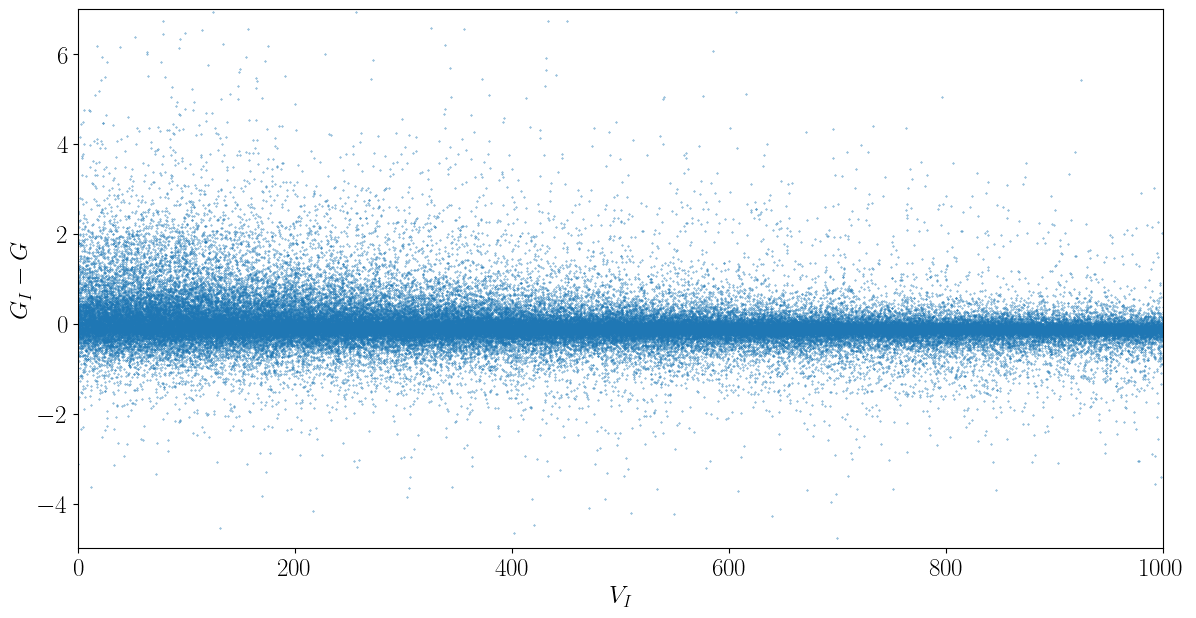

In [6]:
# plot 
plt.figure(figsize=(14, 7))
plt.scatter(data_hvs['VGCR'], data_hvs['implied_M_g_corr']- data_hvs['M_g_corr'], s = 0.1 )
plt.xlim(0, 1e3)
plt.ylim(-5 , 7)
#plt.xscale('log')
plt.xlabel('$V_I$')
plt.ylabel('$G_I - G$')
plt.savefig(os.path.join(plots_path, 'deviation_in_mag_vs_velocity.png'), dpi = 300)
plt.show()

In [12]:
data_hvs

,r0,phi0,theta0,v0,phiv0,thetav0,m,tage,tflight,sep,...,A_bp,A_rp,G_corr,phot_bp_mean_mag_corr,phot_rp_mean_mag_corr,bp_rp_corr,implied_M_g,implied_M_g_corr,M_g_corr,implied_M_g_corr_error
4,3.0,5.955044,2.746694,703.619440,5.955044,2.746694,2.357530,589.570870,12.755775,149.056695,...,0.113363,0.066382,14.930952,14.966184,14.834781,0.131403,0.536440,0.448933,0.538166,0.540211
9,3.0,3.120194,0.629788,575.081502,3.120194,0.629788,0.838266,11451.128421,49.941936,74.950063,...,0.658464,0.385578,20.217732,20.602797,19.648757,0.954040,5.775159,5.266880,5.378828,5.948569
10,3.0,1.958814,2.278024,753.823406,1.958814,2.278024,1.640412,1792.647594,14.488444,115.789742,...,0.894022,0.523513,17.241414,17.403672,16.868296,0.535376,2.183385,1.493275,1.905307,2.230665
20,3.0,4.325877,2.108429,2163.309017,4.325877,2.108429,2.362265,16.972422,12.796420,71.740891,...,0.588226,0.344448,18.719805,18.627797,18.741440,-0.113644,1.698526,1.244465,1.309740,2.029592
27,3.0,5.497562,2.894677,756.665595,5.497562,2.894677,0.871753,12658.965123,33.912047,73.986932,...,0.033113,0.019390,20.382405,20.727596,19.870177,0.857419,4.764700,4.739140,4.820718,4.946842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138559,3.0,2.304521,0.461002,876.493935,2.304521,0.461002,1.775668,523.650938,27.823459,109.660258,...,0.166429,0.097456,18.340871,18.361880,18.261909,0.099971,1.831127,1.702658,1.872346,1.751251
1138564,3.0,2.224904,2.131768,1406.046555,2.224904,2.131768,1.508256,1987.816416,31.592078,9.584620,...,0.141175,0.082668,20.521678,20.713283,20.178266,0.535017,2.259199,2.150224,2.327464,3.280779
1138570,3.0,6.278136,1.241513,3402.772528,6.278136,1.241513,0.864619,2265.674977,4.832035,4.298497,...,0.149588,0.087594,20.379839,20.761842,19.826299,0.935543,5.539412,5.423943,5.544946,5.390361
1138571,3.0,2.061502,2.091054,609.805760,2.061502,2.091054,1.579931,605.309976,14.192854,76.395701,...,1.495263,0.875583,17.494071,17.534679,17.221407,0.313273,2.082792,0.928575,2.577190,2.253563


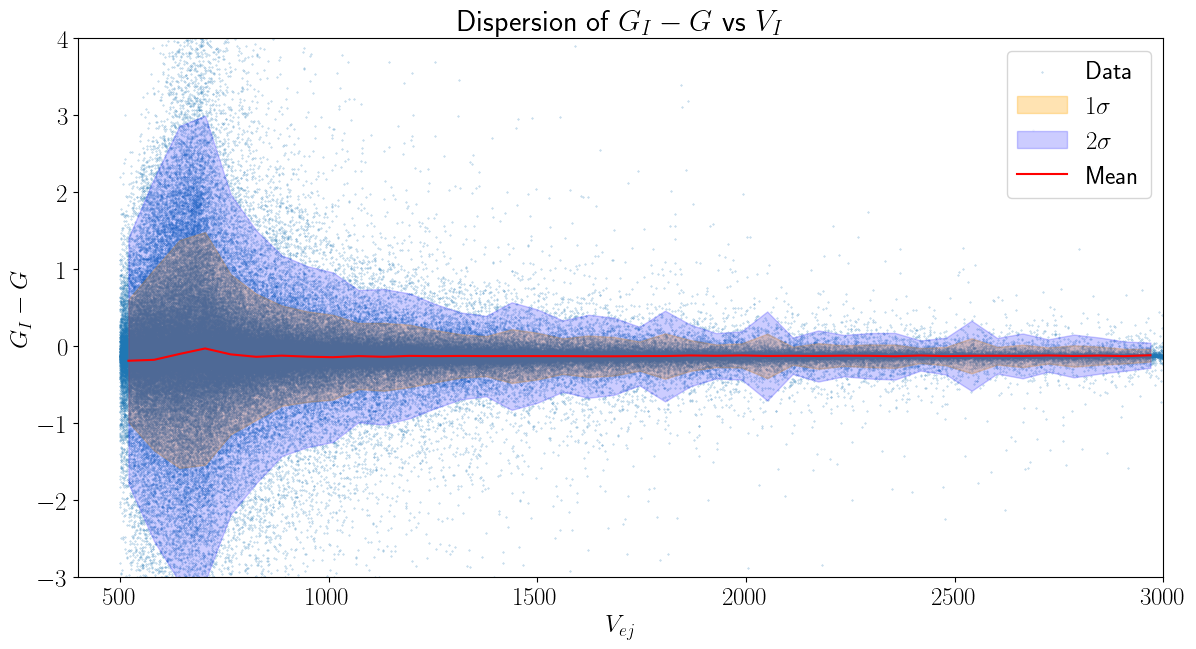

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Filter invalid data
valid_mask = data_hvs['v0'].notnull() & np.isfinite(data_hvs['v0']) & \
             (data_hvs['implied_M_g_corr'] - data_hvs['M_g_corr']).notnull()
data_hvs = data_hvs[valid_mask]

# Data
x = data_hvs['v0']
y = data_hvs['implied_M_g_corr'] - data_hvs['M_g_corr']

# Bin the data along the X-axis
bins = np.linspace(0, 3e3, 50)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
y_mean = []
y_std = []

# Compute mean and standard deviation in each bin
for i in range(len(bins) - 1):
    mask = (x >= bins[i]) & (x < bins[i + 1])
    y_in_bin = y[mask]
    if len(y_in_bin) > 0:
        y_mean.append(np.mean(y_in_bin))
        y_std.append(np.std(y_in_bin))
    else:
        y_mean.append(np.nan)
        y_std.append(np.nan)

y_mean = np.array(y_mean)
y_std = np.array(y_std)

# Plot the data and sigma levels
plt.figure(figsize=(14, 7))
plt.scatter(x, y, s=0.1, alpha=0.5, label="Data")
plt.xlim(400, 3e3)
plt.ylim(-3, 4)

# Plot 1σ and 2σ levels
plt.fill_between(bin_centers, y_mean - y_std, y_mean + y_std, color='orange', alpha=0.3, label=r"$1\sigma$")
plt.fill_between(bin_centers, y_mean - 2 * y_std, y_mean + 2 * y_std, color='blue', alpha=0.2, label=r"$2\sigma$")
plt.plot(bin_centers, y_mean, color='red', lw=1.5, label="Mean")

# # Labels and legend
plt.xlabel(r'$V_{ej}$')
plt.ylabel(r'$G_I - G$')
plt.title(r'Dispersion of $G_I - G$ vs $V_I$')
plt.legend()
#plt.savefig(os.path.join(plots_path, 'dispersion_deviation_in_mag_vs_velocity.png'), dpi = 300)

plt.show()


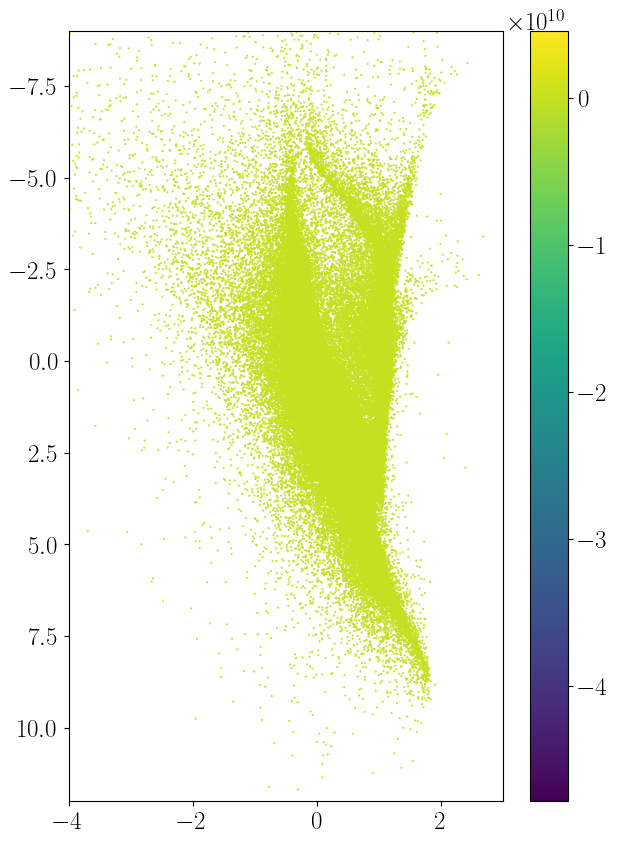

In [8]:
# CMD
plt.figure(figsize=(7, 10))
cbar = plt.scatter(data_hvs['bp_rp_corr'], data_hvs['implied_M_g_corr'], c =data_hvs['VR'], s = 0.3 )
plt.colorbar(cbar)
plt.xlim(-4, 3)
plt.ylim(12, -9)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# Truncate VR values to the range [0, 1e3]
truncated_VR = np.clip(data_hvs['VGCR'], 0, 1e3)

# Normalize the values to 10 levels
norm = Normalize(vmin=0, vmax=1e3)

# Create the scatter plot
plt.figure(figsize=(7, 10))
scatter = plt.scatter(
    data_hvs['bp_rp_corr'], 
    data_hvs['implied_M_g_corr'], 
    c=truncated_VR, 
    s=0.3, 
    cmap='viridis',  # Adjust the colormap as needed
    norm=norm
)
plt.colorbar(scatter, label="VR (Truncated and Normalized)")
plt.xlim(-4, 3)
plt.ylim(12, -9)
plt.xlabel('bp_rp_corr')
plt.ylabel('implied_M_g_corr')
plt.title('Color-Magnitude Diagram')
plt.show()


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import os
import imageio

# Ensure data is truncated
truncated_VR = np.clip(data_hvs['VGCR'], 0, 1e3)
bp_rp_corr = data_hvs['bp_rp_corr']
implied_M_g_corr = data_hvs['implied_M_g_corr']

# Output directory for frames
output_dir = "frames"
os.makedirs(output_dir, exist_ok=True)

# Slider values to iterate over
vr_limits = np.linspace(0, 1000, 50)  # Adjust the number of steps if needed

# Generate frames
for i, vr_limit in enumerate(vr_limits):
    fig, ax = plt.subplots(figsize=(7, 10))

    # Filter the data based on the current VR limit
    mask = truncated_VR > vr_limit
    filtered_bp_rp_corr = bp_rp_corr[mask]
    filtered_implied_M_g_corr = implied_M_g_corr[mask]
    filtered_VR = truncated_VR[mask]

    # Create the scatter plot
    sc = ax.scatter(
        filtered_bp_rp_corr,
        filtered_implied_M_g_corr,
        #c=filtered_VR,
        s=0.3,
        alpha= 0.2,
        #cmap='viridis',
        #norm=Normalize(vmin=0, vmax=1e3)
    )
    ax.set_xlim(-1, 2)
    ax.set_ylim(12, -9)
    ax.set_xlabel('$G_{bp} - G_{rp}$')
    ax.set_ylabel('$G_{I}$')
    ax.set_title(f'Stars with $V_I > {vr_limit:.1f}$')
    #fig.colorbar(sc, ax=ax, label="VR (Truncated)")

    # Save the frame
    frame_path = os.path.join(output_dir, f"frame_{i:03d}.png")
    plt.savefig(frame_path, dpi=300)
    plt.close(fig)

# Create GIF
frames = [imageio.imread(os.path.join(output_dir, f"frame_{i:03d}.png")) for i in range(len(vr_limits))]
output_gif = "VR_threshold_animation.gif"
imageio.mimsave(output_gif, frames, fps=10, loop = 0)  # Adjust fps for speed

# Cleanup: Uncomment if you want to delete frames after creating the GIF
# for frame in os.listdir(output_dir):
#     os.remove(os.path.join(output_dir, frame))
# os.rmdir(output_dir)

print(f"GIF saved as {output_gif}")


/var/folders/__/n140hqf972zfmtt1hs5ldglw0000gn/T/ipykernel_42433/1118767700.py:52: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames = [imageio.imread(os.path.join(output_dir, f"frame_{i:03d}.png")) for i in range(len(vr_limits))]


GIF saved as VR_threshold_animation.gif
